In [1]:
import pandas as pd
import numpy as np

import optuna
from reservoirpy.observables import mse
from sklearn.preprocessing import RobustScaler
from optuna.visualization.matplotlib import (
    plot_slice,
    plot_contour,
    plot_param_importances,
)

from optuna_training import (
    ProcessedData,
    ModelConfiguration,
    get_3D_prediction_list,
    remove_warmup,
)
from optuna_post_processing import (
    get_predictions_dataframe,
    get_worst_individuals,
    plot_individual_results,
)

pd.options.display.max_rows = 20
pd.options.display.max_columns = 300

using a local optuna!


/home/francois/miniforge-pypy3/envs/reservoirs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CSV_FILE = "../../data/synthetic_bph_1/Simulations/01_test.csv"

In [3]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data = data.sort_values(by=["individus", "temps"])
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,x2_x5,x4_x7,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,8.729390,8.605198,-6.255856,-6.144225,-2.996805,-2.991126,2.307527,2.279975,4.616573,4.615336,38.220878,38.163806,4.187466e+00,4.181621,0,-28.880618,9.662692e+00,-43.498706,-43.605232,-15.862629,-15.991621
1,1,1,9.075289,9.704948,-6.018428,-6.112985,-2.996020,-3.094470,2.252828,2.150593,2.317368,2.317199,39.248562,39.245740,3.712258e+00,3.709538,0,-13.946913,8.363078e+00,-20.211433,-20.401545,-7.797185,-7.829579
2,1,2,9.421187,9.596647,-5.879542,-5.801847,-2.993664,-2.938728,2.203334,2.420423,0.932058,0.930796,40.289880,40.332412,3.249134e+00,3.235153,0,-5.480074,7.158927e+00,-7.072602,-7.057319,-3.222236,-3.226070
3,1,3,9.767085,10.198744,-5.781001,-5.883516,-2.989738,-3.019894,2.158550,1.996865,0.334789,0.334388,41.344832,41.291154,2.808980e+00,2.806895,0,-1.935418,6.063324e+00,-1.653218,-1.594787,-1.304205,-1.367045
4,1,4,10.112983,9.873528,-5.704566,-5.616327,-2.984241,-2.908691,2.118027,1.878657,0.114954,0.113111,42.413417,42.368055,2.400529e+00,2.400502,0,-0.655763,5.084385e+00,0.223129,0.180240,-0.609093,-0.547249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-2.462644,-2.583611,-1.008648,-1.005435,-3.012749,-3.218416,1.540358,1.520395,7.755539,7.756008,52.689242,52.714643,9.081671e-09,0.003654,1,-7.822612,1.398902e-08,1.100055,0.990910,-4.453522,-4.409573
12996,500,22,-2.972811,-3.602696,-0.961010,-0.870865,-3.008361,-3.028149,1.553460,1.607670,7.756674,7.756364,53.279452,53.282305,3.401095e-09,-0.003304,1,-7.454240,5.283465e-09,1.047838,1.071853,-4.254718,-4.326941
12997,500,23,-3.482978,-2.910034,-0.915399,-0.987839,-3.003769,-3.071758,1.565315,1.596924,7.757462,7.756919,53.872949,53.850949,1.273714e-09,-0.002870,1,-7.101176,1.993764e-09,0.997791,0.990856,-4.064175,-4.332440
12998,500,24,-3.993145,-3.816640,-0.871651,-0.968017,-2.998973,-2.887558,1.576042,1.661724,7.758010,7.759375,54.469734,54.366824,4.770072e-10,-0.007898,1,-6.762277,7.517835e-10,0.949751,0.920250,-3.881277,-3.802191


In [4]:
SERIES_COLUMN_NAME = "individus"
TIMESTEPS_COLUMN_NAME = "temps"
N_WARMUPS = 3

# Objective function for Optuna

For each set/trial of hyper-parameters, we use 5 random seeds to generate a reservoir.  

For each (seed) reservoir, we compute de MSE on the predictions.  
Then we calculate the mean of these (seed) MSE.  
The best set/trial of hyper-parameters correspond to the minimal value of this MSE.

$min_{HP} \left( mean_{seed} \left( MAE_{pred} \right) \right)$

In [5]:
N_SEEDS = 5

In [6]:
# https://reservoirpy.readthedocs.io/en/latest/user_guide/hyper.html#Optimize-hyperparameters

grid_search_space = {
    "N": [100, 500],
    "sr": [1e-1, 1e1],
    "lr": [1e-2, 1e0],
    "input_scaling_0": [1e0],
    "input_scaling_1": [1e0],
    "input_scaling_2": [1e0],
    "input_scaling_3": [1e0],
    "input_scaling_4": [1e0],
    "input_scaling_5": [1e0],
    "input_scaling_6": [1e0],
    "input_scaling_7": [1e0],
    "ridge": [1e-4, 1e-2],
    "input_to_readout": [True, False],
    "readout_feedback_to_reservoir": [True, False],
}
from itertools import product

N_space = len(list(product(*grid_search_space.values())))
if N_space > 100:
    raise UserWarning(f"The grid search space size is {N_space} !")


def get_model_list(trial, x_labels):

    reservoir_kwargs = {
        "units": trial.suggest_int("N", 50, 1000),
        "sr": trial.suggest_float("sr", 1e-2, 1e1, log=True),
        "lr": trial.suggest_float("lr", 1e-3, 1e0, log=True),
        # SUPER! tu as décalé l'indice de l'input_scaling avec celui du x correspondant <3
        "input_scaling": [
            trial.suggest_float(f"input_scaling_{i}", 1e-3, 1e2, log=True)
            for i, _ in enumerate(x_labels)
        ],
    }

    ridge_kwargs = {
        #  "ridge": trial.suggest_float("ridge", 1e-8, 1e1, log=True),
        "ridge": trial.suggest_float("ridge", 1e-10, 1e1, log=True),
    }

    fit_kwargs = {
        "warmup": N_WARMUPS,
    }

    return [
        ModelConfiguration(
            input_kwargs={},
            reservoir_kwargs=reservoir_kwargs,
            ridge_kwargs=ridge_kwargs,
            fit_kwargs=fit_kwargs,
            input_to_readout=trial.suggest_categorical(
                "input_to_readout", [True, False]
            ),
            readout_feedback_to_reservoir=trial.suggest_categorical(
                "readout_feedback_to_reservoir", [True, False]
            ),
        )
        for reservoir_kwargs["seed"] in range(42, 42 + N_SEEDS)
    ]

In [7]:
def optuna_objective(trial, processed_data):

    model_list = get_model_list(trial, processed_data.x_labels)
    list_mse = [
        mse(
            remove_warmup(processed_data.y_test_3D, N_WARMUPS),
            remove_warmup(y_hat_3D, N_WARMUPS),
        )
        for y_hat_3D in get_3D_prediction_list(model_list, processed_data, n_cpus=4)
    ]
    return np.mean(list_mse)

# Baseline => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target without random effects

In [8]:
STUDY_NAME = "Cheat-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name" "$df_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_fixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.GridSampler(grid_search_space, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
    )

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=20, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=40,
# )
######################

print(f"{len(study.trials)} trials found.")

Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.


[I 2024-11-05 14:47:04,718] Using an existing study with name 'Cheat-Capacity' instead of creating a new one.


229 trials found.


In [9]:
# %rm "$df_name"

try:
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
except FileNotFoundError:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=4)
    df_pred.to_pickle(df_name)
df_pred

,individus,temps,y_fixed,prediction-0,error-0,prediction-1,error-1,prediction-2,error-2,prediction-3,error-3,prediction-4,error-4,mean-absolute-error
0,1,0,-15.862629,-15.862629,-1.788791e-12,-15.862629,-4.050094e-13,-15.862629,-2.254197e-12,-15.862629,-1.573852e-12,-15.862629,-3.366196e-12,1.877609e-12
1,1,1,-7.797185,-7.797185,1.376677e-13,-7.797185,1.666223e-12,-7.797185,-8.384404e-13,-7.797185,-7.993606e-14,-7.797185,-1.683986e-12,8.812506e-13
2,1,2,-3.222236,-3.222236,7.331913e-13,-3.222236,2.491785e-12,-3.222236,3.241851e-14,-3.222236,5.182521e-13,-3.222236,-1.342482e-12,1.023626e-12
3,1,3,-1.304205,-1.304205,4.003464e-13,-1.304205,2.484457e-12,-1.304205,3.141931e-13,-1.304205,6.057377e-13,-1.304205,-1.582734e-12,1.077494e-12
4,1,4,-0.609093,-0.609093,-1.192380e-13,-0.609093,2.154610e-12,-0.609093,3.919087e-13,-0.609093,5.113687e-13,-0.609093,-1.870060e-12,1.009437e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-4.453522,-4.453522,6.741274e-13,-4.453522,-2.200018e-12,-4.453522,-4.551914e-12,-4.453522,3.425704e-12,-4.453522,-2.212452e-12,2.612843e-12
12996,500,22,-4.254718,-4.254718,8.606449e-13,-4.254718,-2.057021e-12,-4.254718,-4.972911e-12,-4.254718,3.229417e-12,-4.254718,-2.332357e-12,2.690470e-12
12997,500,23,-4.064175,-4.064175,1.080913e-12,-4.064175,-1.907807e-12,-4.064175,-5.394796e-12,-4.064175,3.042011e-12,-4.064175,-2.444267e-12,2.773959e-12
12998,500,24,-3.881277,-3.881277,1.337153e-12,-3.881277,-1.759926e-12,-3.881277,-5.795808e-12,-3.881277,2.862155e-12,-3.881277,-2.529976e-12,2.857004e-12


Returning the 2 worst MAE individuals (mean over seeds and timesteps).


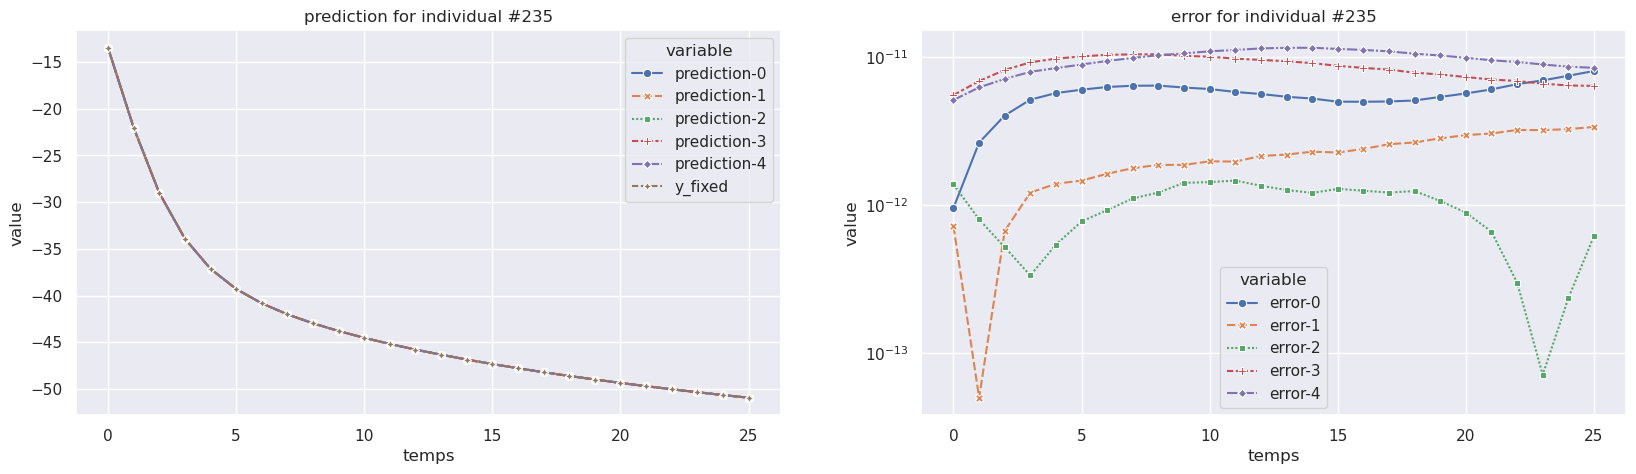

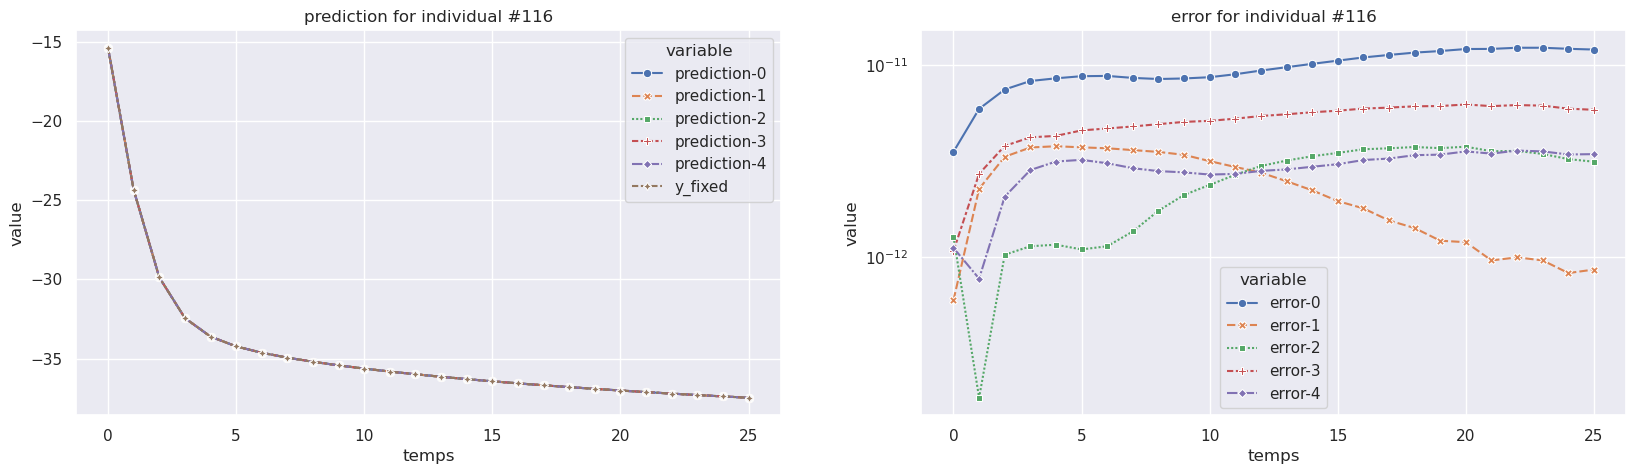

In [10]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

/tmp/ipykernel_32094/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

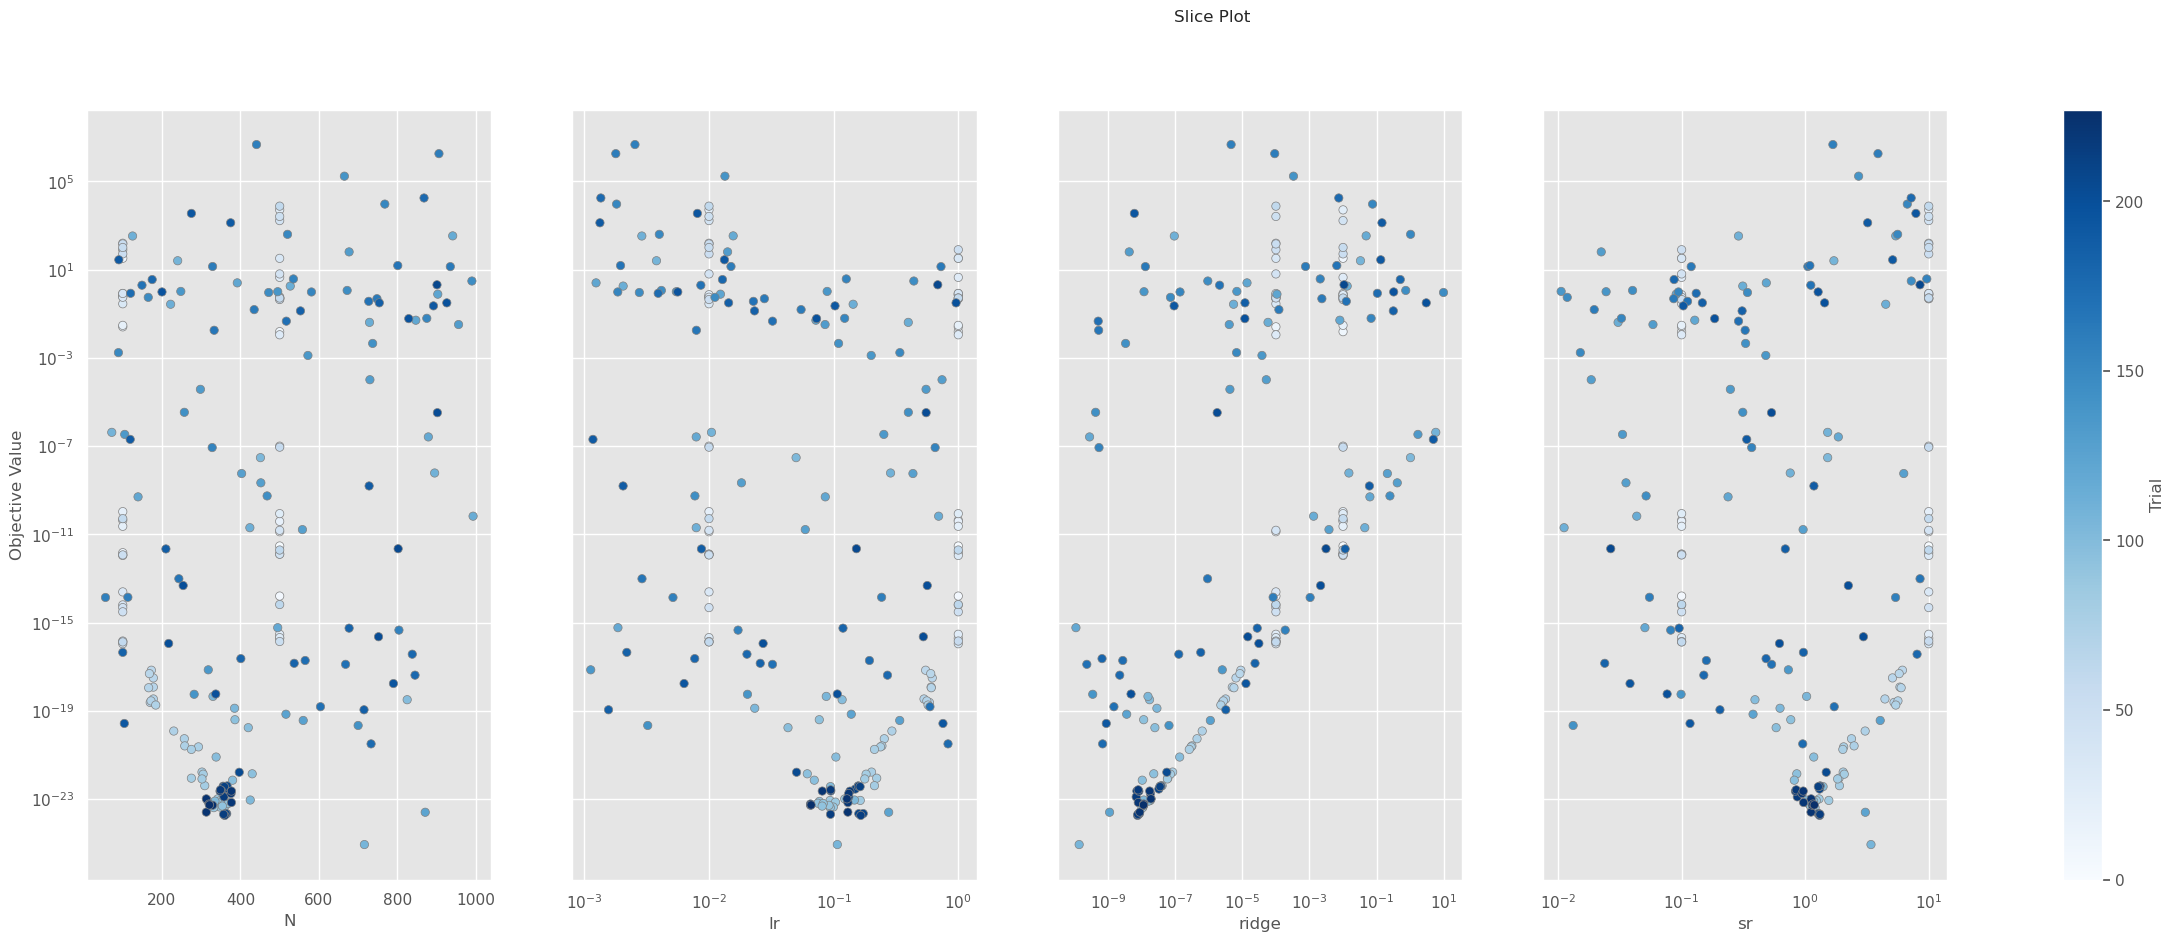

In [11]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

# Baseline => Generalization 

In [14]:
STUDY_NAME = "Cheat-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name" "$df_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = ["y_fixed"]
y_labels_test = ["y_fixed"]


indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.GridSampler(grid_search_space, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
    )

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=20, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=40,
# )
######################


print(f"{len(study.trials)} trials found.")

[I 2024-11-05 14:48:25,332] Using an existing study with name 'Cheat-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.
179 trials found.


In [15]:
# %rm "$df_name"
try:
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
except FileNotFoundError:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=4)
    df_pred.to_pickle(df_name)
df_pred

,individus,temps,y_fixed,prediction-0,error-0,prediction-1,error-1,prediction-2,error-2,prediction-3,error-3,prediction-4,error-4,mean-absolute-error
10374,400,0,-10.564027,-10.564027,2.273204e-11,-10.564027,4.121148e-13,-10.564027,1.117684e-11,-10.564027,2.585132e-11,-10.564027,2.747136e-11,1.752873e-11
10375,400,1,-10.988730,-10.988730,1.409184e-11,-10.988730,-2.117417e-12,-10.988730,5.915268e-12,-10.988730,2.360601e-11,-10.988730,2.011546e-11,1.316920e-11
10376,400,2,-11.182020,-11.182020,8.370193e-12,-11.182020,-3.719691e-12,-11.182020,4.284573e-12,-11.182020,1.942979e-11,-11.182020,1.207390e-11,9.575629e-12
10377,400,3,-11.281375,-11.281375,6.345147e-12,-11.281375,-3.163692e-12,-11.281375,5.268674e-12,-11.281375,1.671907e-11,-11.281375,6.471268e-12,7.593570e-12
10378,400,4,-11.329438,-11.329438,4.963141e-12,-11.329438,-8.064660e-13,-11.329438,9.498180e-12,-11.329438,1.176481e-11,-11.329438,3.840483e-12,6.174616e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-4.453522,-4.453522,4.220180e-11,-4.453522,2.778933e-11,-4.453522,3.578116e-11,-4.453522,4.162448e-11,-4.453522,3.912692e-11,3.730474e-11
12996,500,22,-4.254718,-4.254718,4.336176e-11,-4.254718,2.792788e-11,-4.254718,3.473932e-11,-4.254718,4.233858e-11,-4.254718,3.971401e-11,3.761631e-11
12997,500,23,-4.064175,-4.064175,4.454215e-11,-4.064175,2.808775e-11,-4.064175,3.351985e-11,-4.064175,4.303491e-11,-4.064175,4.034728e-11,3.790639e-11
12998,500,24,-3.881277,-3.881277,4.571232e-11,-3.881277,2.830358e-11,-3.881277,3.227507e-11,-3.881277,4.384626e-11,-3.881277,4.101297e-11,3.823004e-11


Returning the 2 worst MAE individuals (mean over seeds and timesteps).


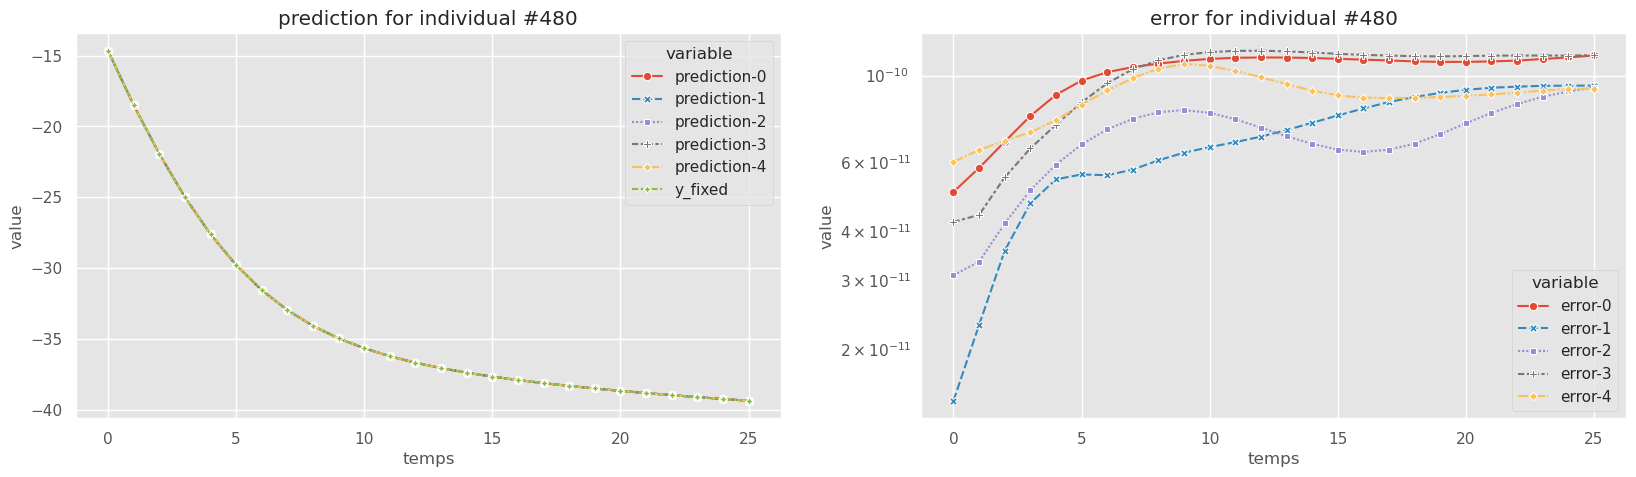

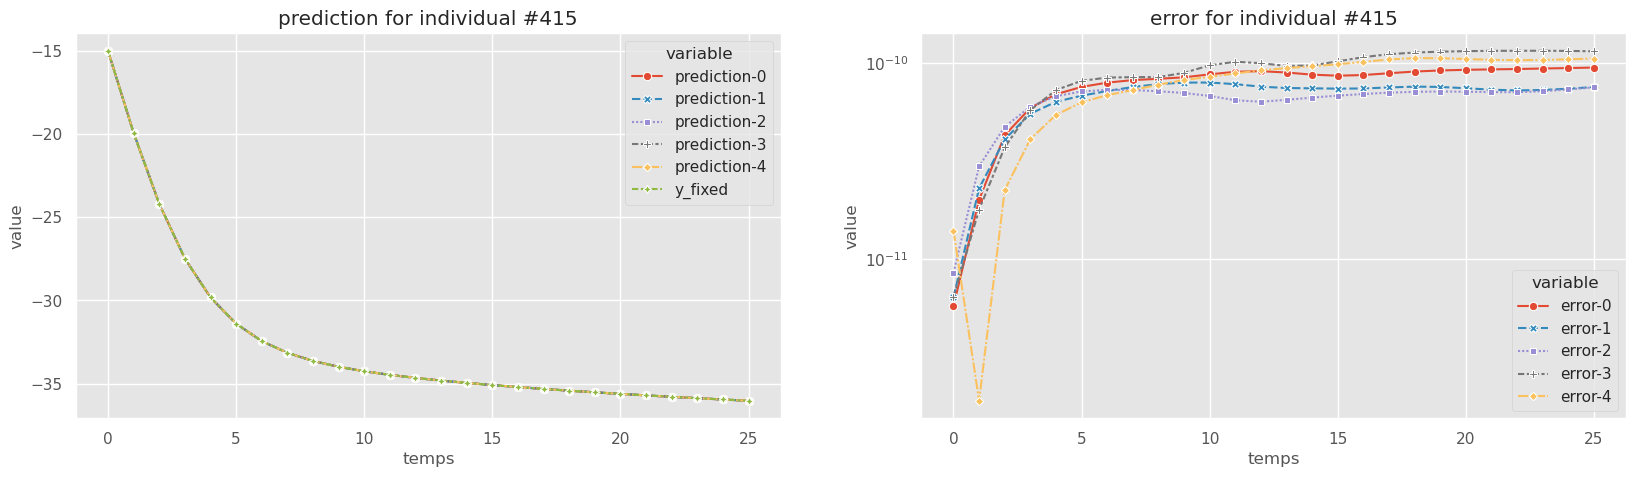

In [16]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

/tmp/ipykernel_32094/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

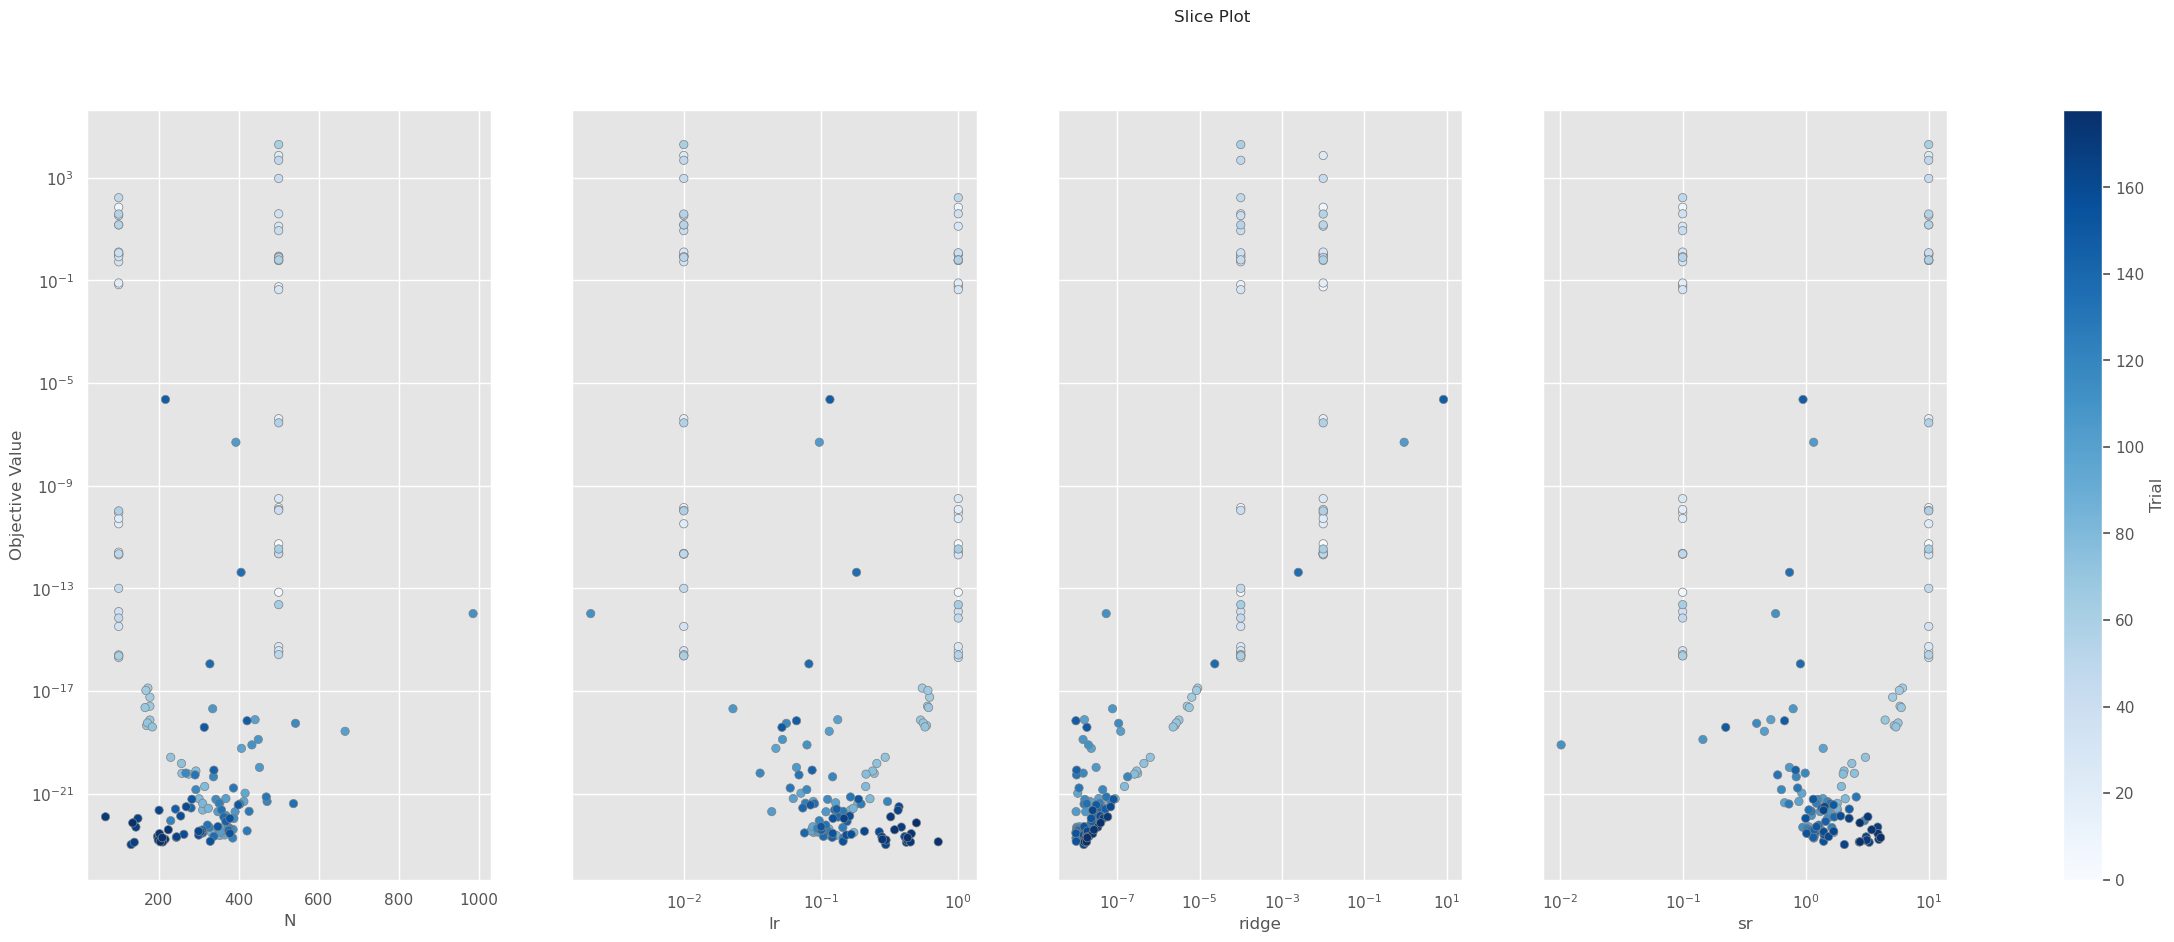

In [17]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

# Baseline + noise on target

In [18]:
STUDY_NAME = "Cheat-Noisy-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name" "$df_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = ["y_fixed_obs"]
y_labels_test = ["y_fixed"]


indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.GridSampler(grid_search_space, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
    )

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )
print(f"{len(study.trials)} trials found.")

[I 2024-11-05 14:49:38,467] Using an existing study with name 'Cheat-Noisy-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.
90 trials found.


In [19]:
# %rm "$df_name"

try:
    df_pred = pd.read_pickle(df_name)
except FileNotFoundError:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=4)
    df_pred.to_pickle(df_name)
df_pred

,individus,temps,y_fixed,prediction-0,error-0,prediction-1,error-1,prediction-2,error-2,prediction-3,error-3,prediction-4,error-4,mean-absolute-error
10374,400,0,-10.564027,-10.562100,-0.001927,-10.561898,-0.002129,-10.562205,-0.001822,-10.562171,-0.001856,-10.562101,-0.001927,0.001932
10375,400,1,-10.988730,-10.987098,-0.001631,-10.986902,-0.001828,-10.987202,-0.001528,-10.987168,-0.001562,-10.987099,-0.001631,0.001636
10376,400,2,-11.182020,-11.180636,-0.001385,-11.180442,-0.001579,-11.180737,-0.001283,-11.180704,-0.001316,-11.180636,-0.001384,0.001389
10377,400,3,-11.281375,-11.280147,-0.001228,-11.279953,-0.001422,-11.280248,-0.001128,-11.280216,-0.001159,-11.280148,-0.001227,0.001233
10378,400,4,-11.329438,-11.328292,-0.001146,-11.328094,-0.001344,-11.328391,-0.001048,-11.328361,-0.001078,-11.328293,-0.001146,0.001152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-4.453522,-4.453958,0.000436,-4.452881,-0.000641,-4.454137,0.000615,-4.454218,0.000696,-4.453950,0.000428,0.000563
12996,500,22,-4.254718,-4.255154,0.000436,-4.254069,-0.000649,-4.255334,0.000616,-4.255416,0.000698,-4.255146,0.000428,0.000565
12997,500,23,-4.064175,-4.064611,0.000435,-4.063518,-0.000657,-4.064791,0.000616,-4.064874,0.000699,-4.064602,0.000427,0.000567
12998,500,24,-3.881277,-3.881712,0.000434,-3.880612,-0.000665,-3.881894,0.000616,-3.881977,0.000700,-3.881703,0.000426,0.000568


Returning the 2 worst MAE individuals (mean over seeds and timesteps).


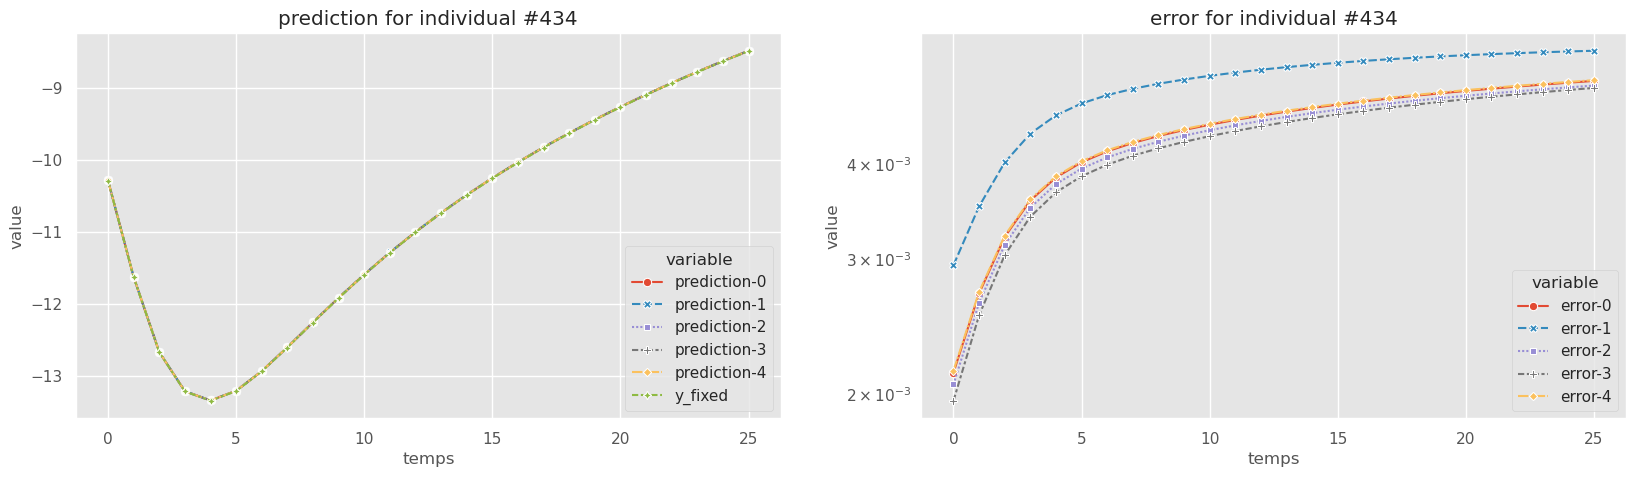

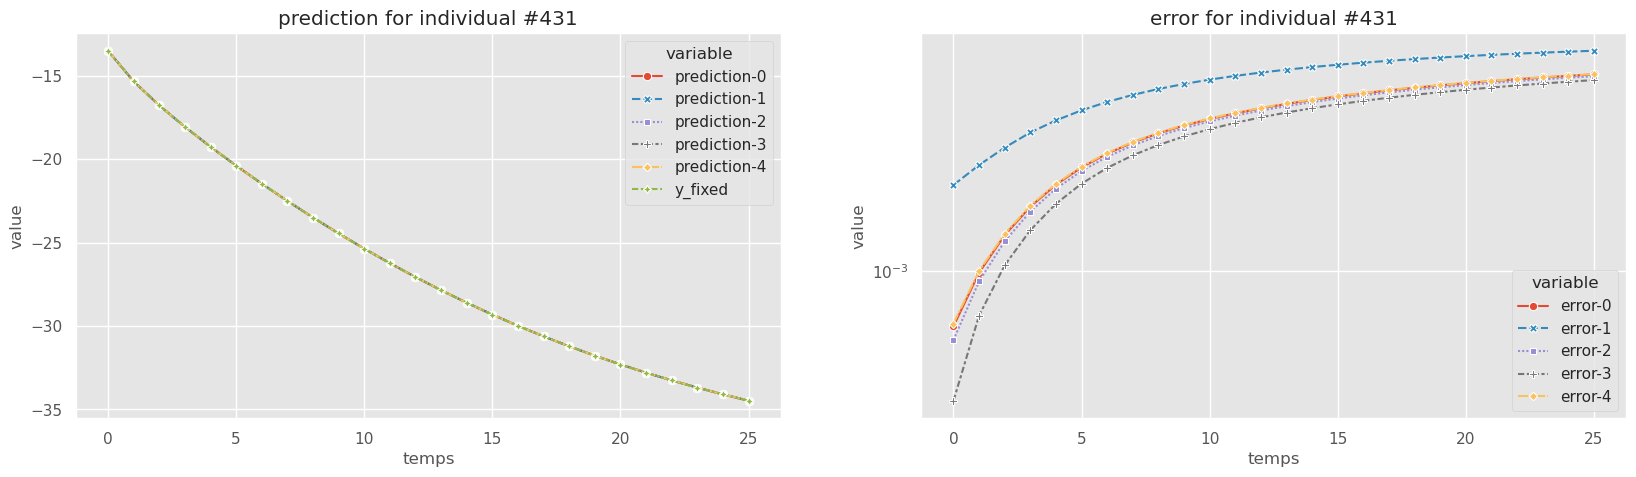

In [18]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

/tmp/ipykernel_43296/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

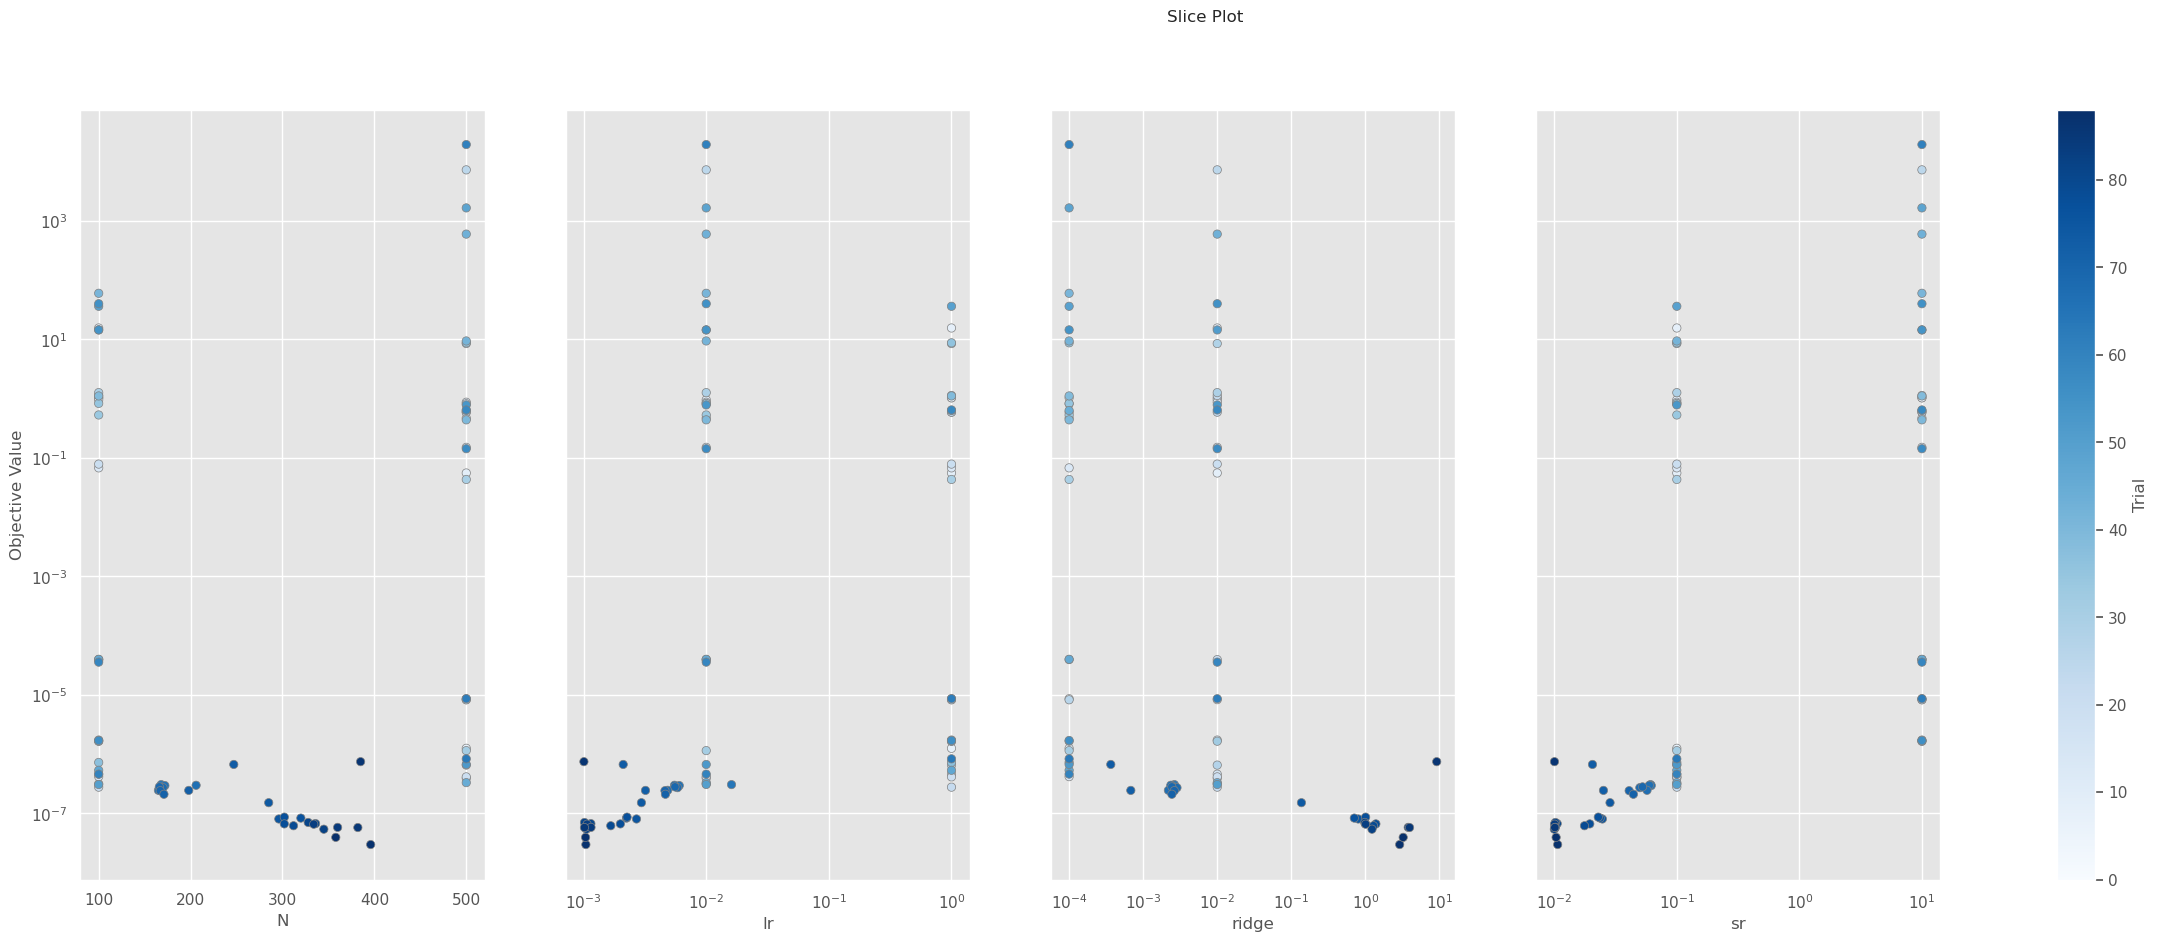

In [19]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

# Baseline + Mixed effects => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target with random effects

In [20]:
STUDY_NAME = "MixedEffect-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name" "$df_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_mixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.GridSampler(grid_search_space, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
    )

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=20, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=40,
# )
######################

print(f"{len(study.trials)} trials found.")

[I 2024-11-05 14:52:42,155] Using an existing study with name 'MixedEffect-Capacity' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.
114 trials found.


In [21]:
# %rm "$df_name"

try:
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
except FileNotFoundError:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=4)
    df_pred.to_pickle(df_name)
df_pred

,individus,temps,y_mixed,prediction-0,error-0,prediction-1,error-1,prediction-2,error-2,prediction-3,error-3,prediction-4,error-4,mean-absolute-error
0,1,0,-43.498706,-28.235567,-15.263139,-27.555229,-15.943477,-30.873935,-12.624771,-27.571246,-15.927460,-23.829388,-19.669318,15.885633
1,1,1,-20.211433,-8.870823,-11.340611,-17.896844,-2.314590,-7.889454,-12.321980,-4.416112,-15.795322,-7.729627,-12.481806,10.850862
2,1,2,-7.072602,-3.003424,-4.069178,-10.698652,3.626050,2.259135,-9.331737,4.667067,-11.739669,-0.872273,-6.200329,6.993393
3,1,3,-1.653218,-2.512844,0.859627,-7.061352,5.408135,5.174740,-6.827957,4.735291,-6.388509,0.316583,-1.969800,4.290806
4,1,4,0.223129,-3.475269,3.698398,-6.528174,6.751303,4.412804,-4.189675,2.151312,-1.928183,-0.733260,0.956389,3.504790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,1.100055,-3.453031,4.553087,-7.345339,8.445394,-5.294585,6.394641,0.683165,0.416890,-2.389181,3.489237,4.659850
12996,500,22,1.047838,-3.378413,4.426251,-7.332781,8.380619,-5.232506,6.280344,0.745699,0.302139,-2.410324,3.458162,4.569503
12997,500,23,0.997791,-3.286050,4.283841,-7.287273,8.285063,-5.146231,6.144022,0.812732,0.185059,-2.444534,3.442325,4.468062
12998,500,24,0.949751,-3.174076,4.123827,-7.210596,8.160347,-5.036545,5.986296,0.888500,0.061251,-2.491473,3.441224,4.354589


Returning the 2 worst MAE individuals (mean over seeds and timesteps).


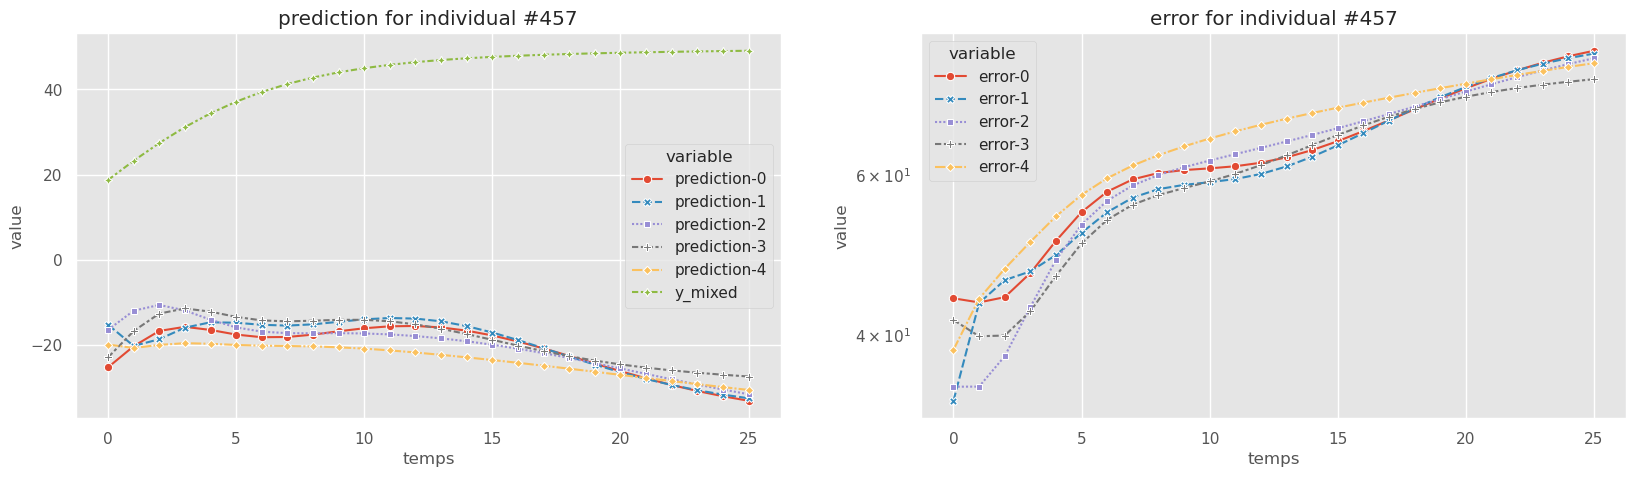

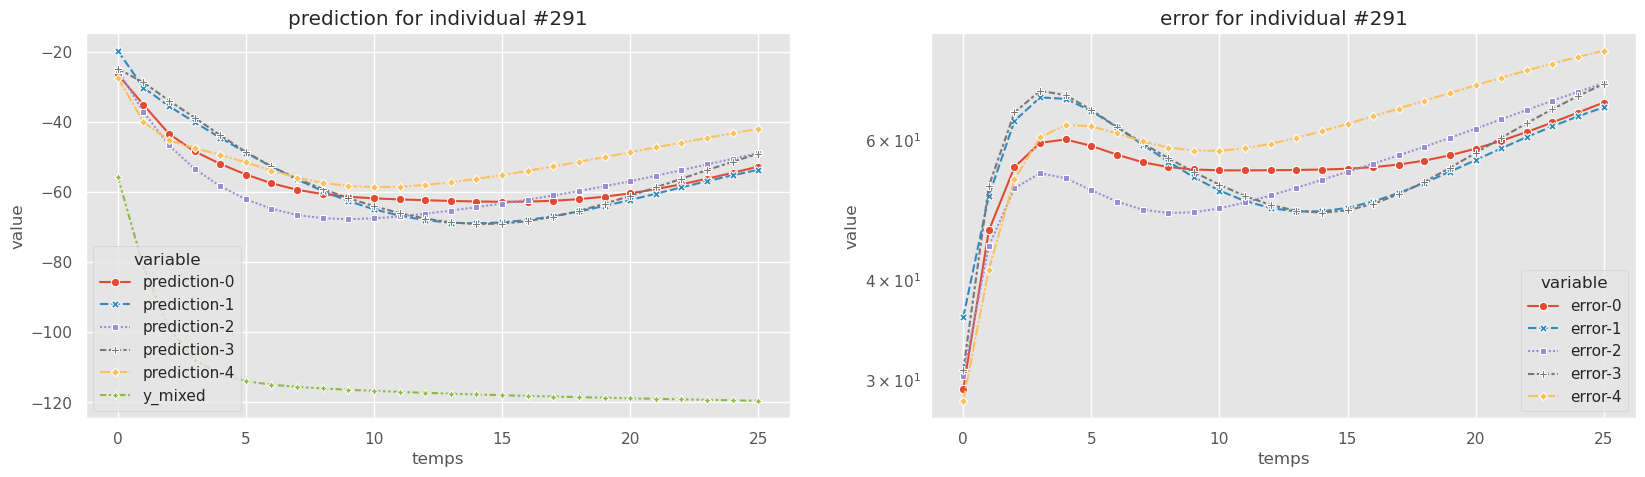

In [24]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

/tmp/ipykernel_32094/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

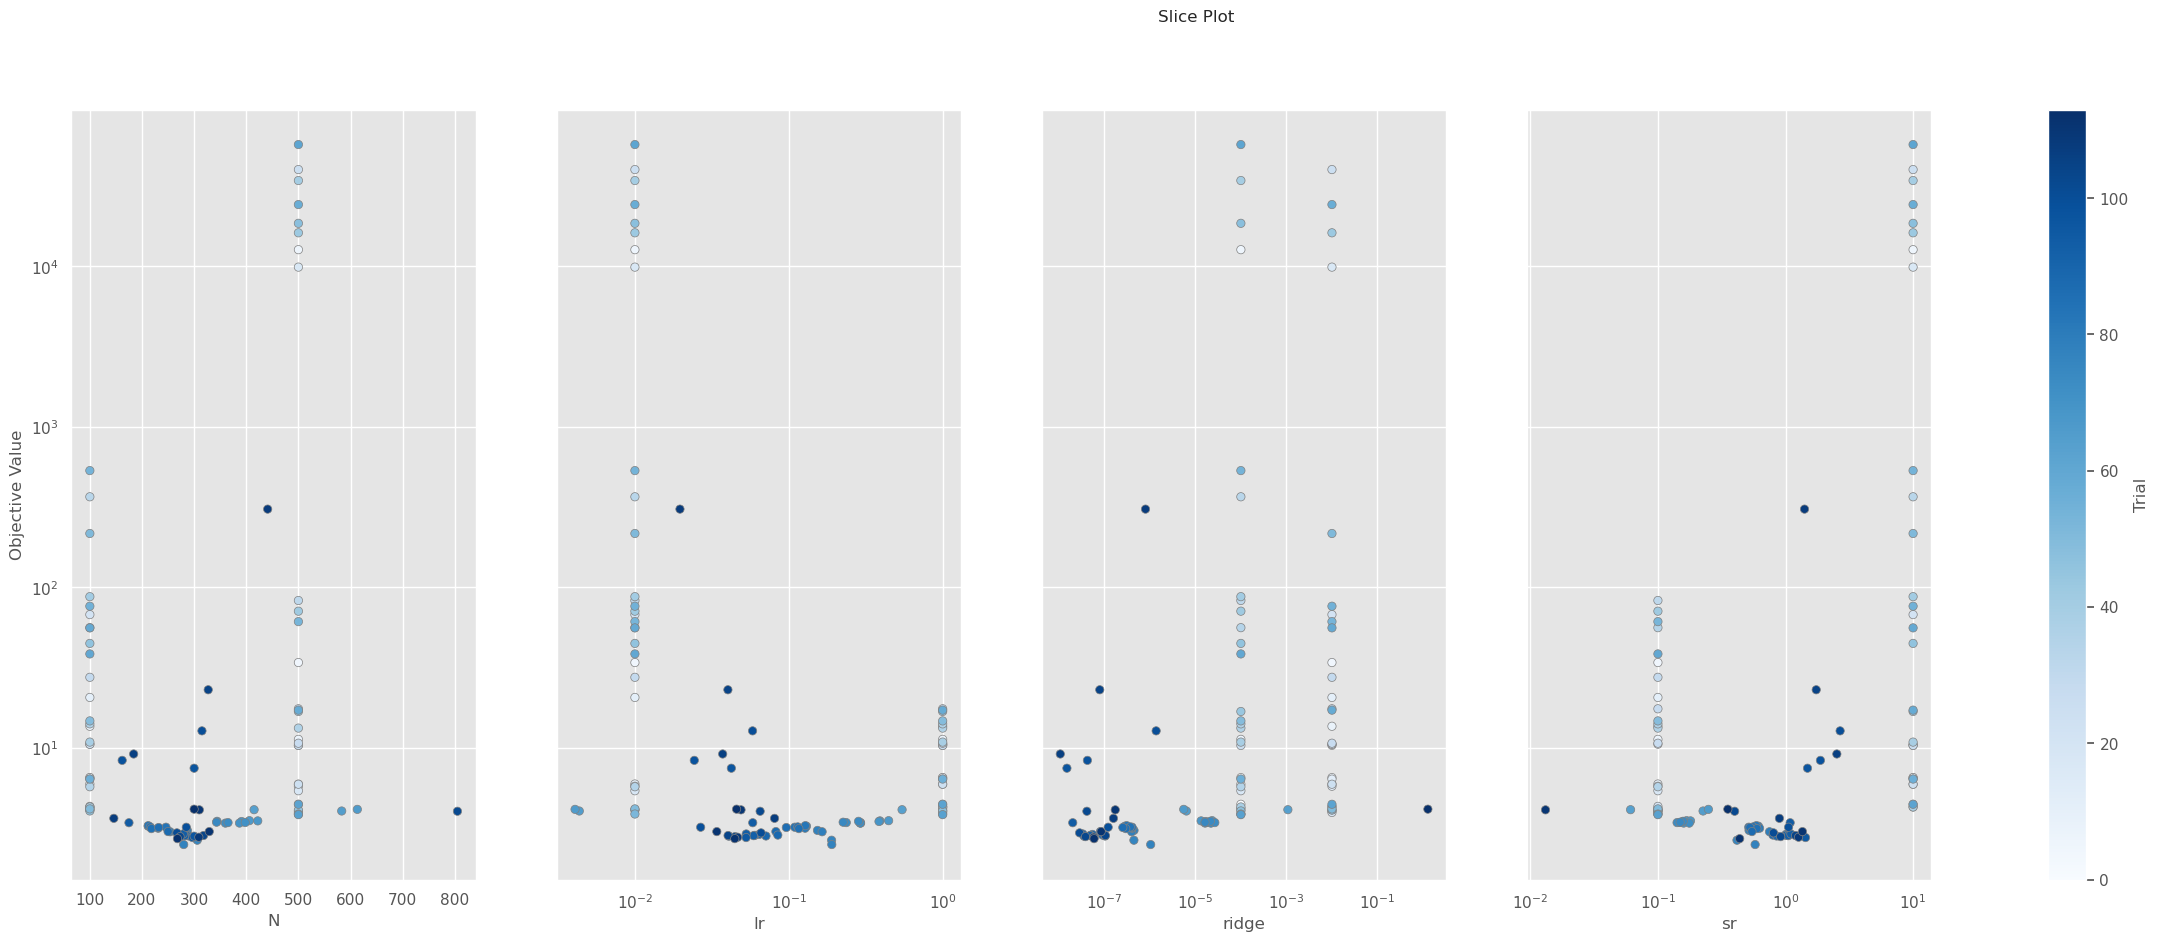

In [25]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

# All numerical features => Capacity

We use:
- features:
  - all numerical features, so ($x_1, ..., x_7$) **but not** $x_8$
  - without noise
- target without random effects

In [26]:
STUDY_NAME = "all-numerical-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name" "$df_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_fixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.GridSampler(grid_search_space, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
    )

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

print(f"{len(study.trials)} trials found.")

[I 2024-11-05 14:54:31,952] Using an existing study with name 'all-numerical-Capacity' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.
164 trials found.


In [27]:
# %rm "$df_name"

try:
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
except FileNotFoundError:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=4)
    df_pred.to_pickle(df_name)
df_pred

,individus,temps,y_fixed,prediction-0,error-0,prediction-1,error-1,prediction-2,error-2,prediction-3,error-3,prediction-4,error-4,mean-absolute-error
0,1,0,-15.862629,-11.718474,-4.144156,-12.481010,-3.381619,-12.112865,-3.749764,-10.858286,-5.004344,-12.192850,-3.669779,3.989933
1,1,1,-7.797185,-6.618001,-1.179185,-7.396555,-0.400630,-7.335404,-0.461781,-6.550974,-1.246212,-7.106812,-0.690373,0.795636
2,1,2,-3.222236,-2.909330,-0.312906,-3.539754,0.317518,-3.297858,0.075622,-3.107465,-0.114771,-3.093351,-0.128885,0.189940
3,1,3,-1.304205,-1.194909,-0.109295,-1.723560,0.419356,-1.271916,-0.032289,-1.410695,0.106491,-1.178264,-0.125940,0.158674
4,1,4,-0.609093,-0.507237,-0.101856,-0.942784,0.333691,-0.404825,-0.204268,-0.669310,0.060217,-0.430476,-0.178617,0.175730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,500,21,-4.453522,-4.296078,-0.157444,-4.293616,-0.159906,-4.402704,-0.050818,-4.418157,-0.035364,-4.442564,-0.010957,0.082898
12996,500,22,-4.254718,-4.094725,-0.159993,-4.086012,-0.168707,-4.199147,-0.055571,-4.216214,-0.038504,-4.237582,-0.017136,0.087982
12997,500,23,-4.064175,-3.902401,-0.161775,-3.886792,-0.177383,-4.003173,-0.061003,-4.021150,-0.043025,-4.040505,-0.023670,0.093371
12998,500,24,-3.881277,-3.718049,-0.163228,-3.695332,-0.185946,-3.814362,-0.066916,-3.832620,-0.048657,-3.850844,-0.030434,0.099036


Returning the 2 worst MAE individuals (mean over seeds and timesteps).


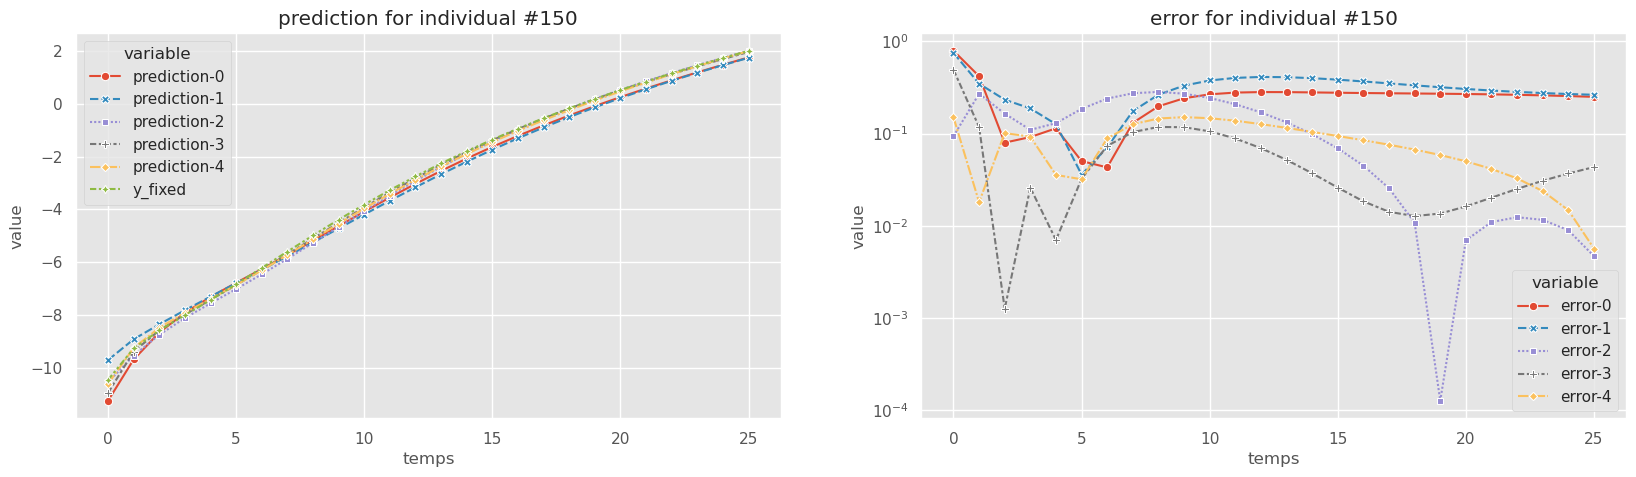

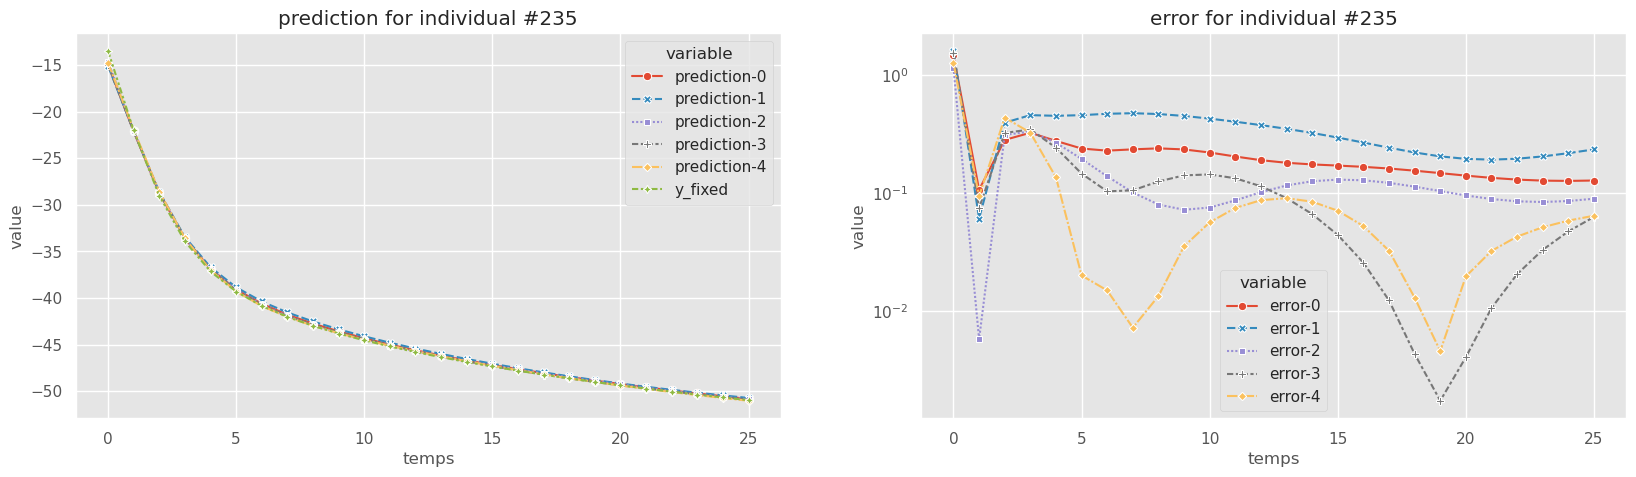

In [28]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

/tmp/ipykernel_32094/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

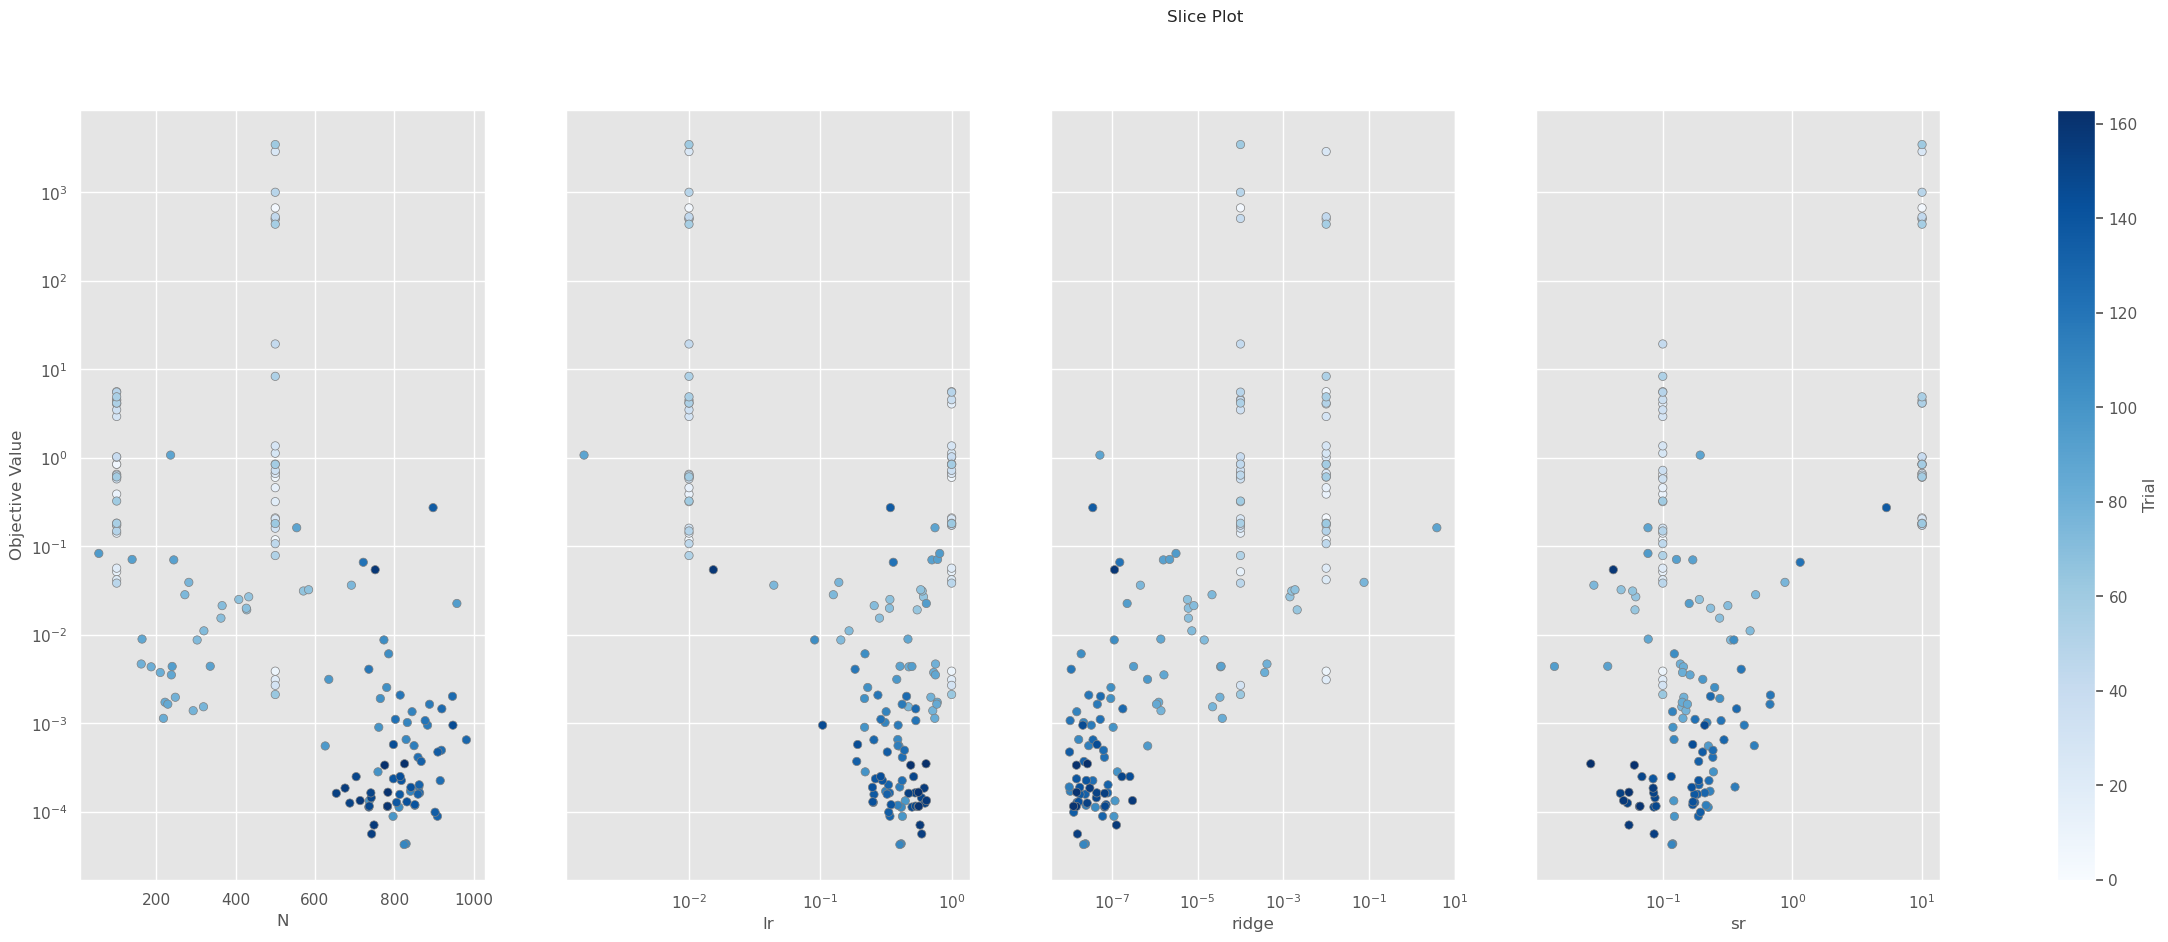

In [29]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

We check if the HP optimization helps selecting the informative variables.

These input scaling should be high:

/tmp/ipykernel_32094/3381251238.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(


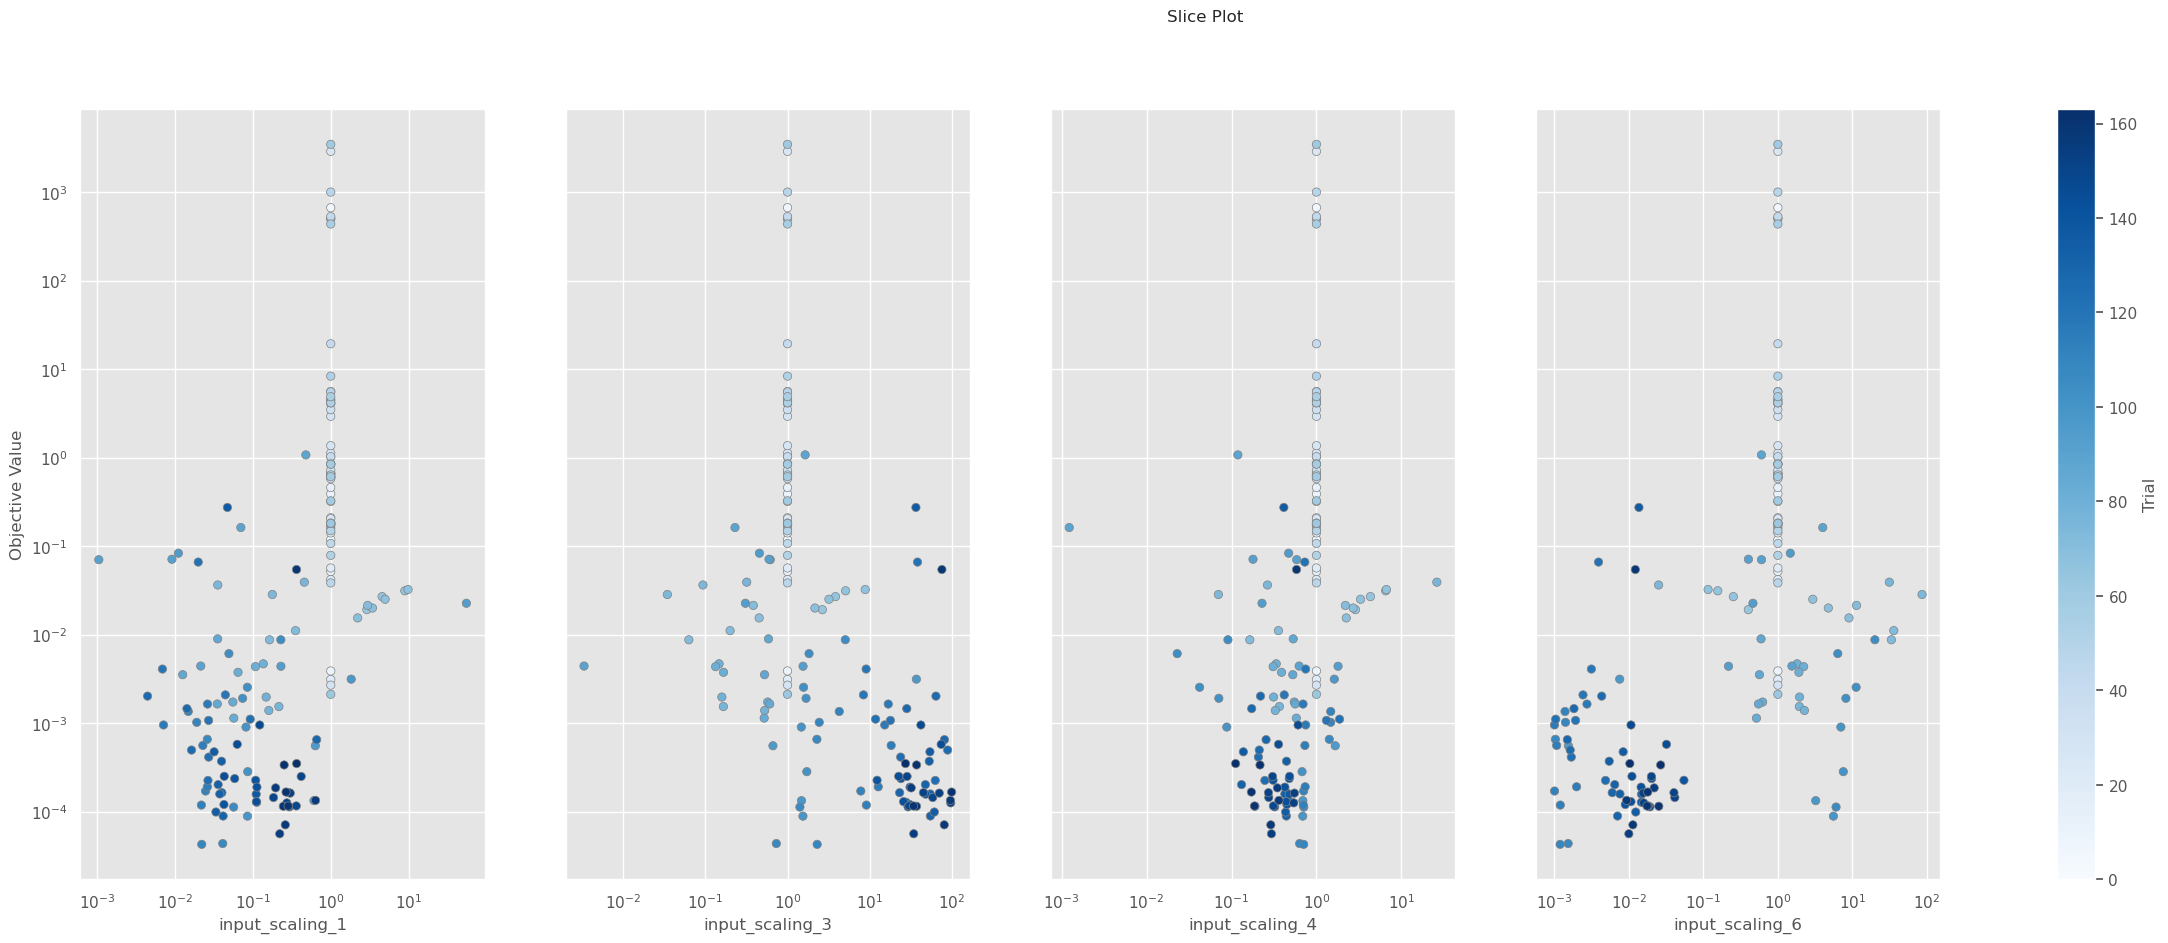

In [31]:
# "x2_x5" and "x4_x7"

axes = plot_slice(
    study,
    params=[
        # "input_scaling_0", # x1
        "input_scaling_1",  # x2
        # "input_scaling_2", # x3
        "input_scaling_3",  # x4
        "input_scaling_4",  # x5
        # "input_scaling_5", # x6
        "input_scaling_6",  # x7
    ],
)
ax = axes[0]
ax.set_yscale("log")

These input scalings should be low:

/tmp/ipykernel_32094/3759826663.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(


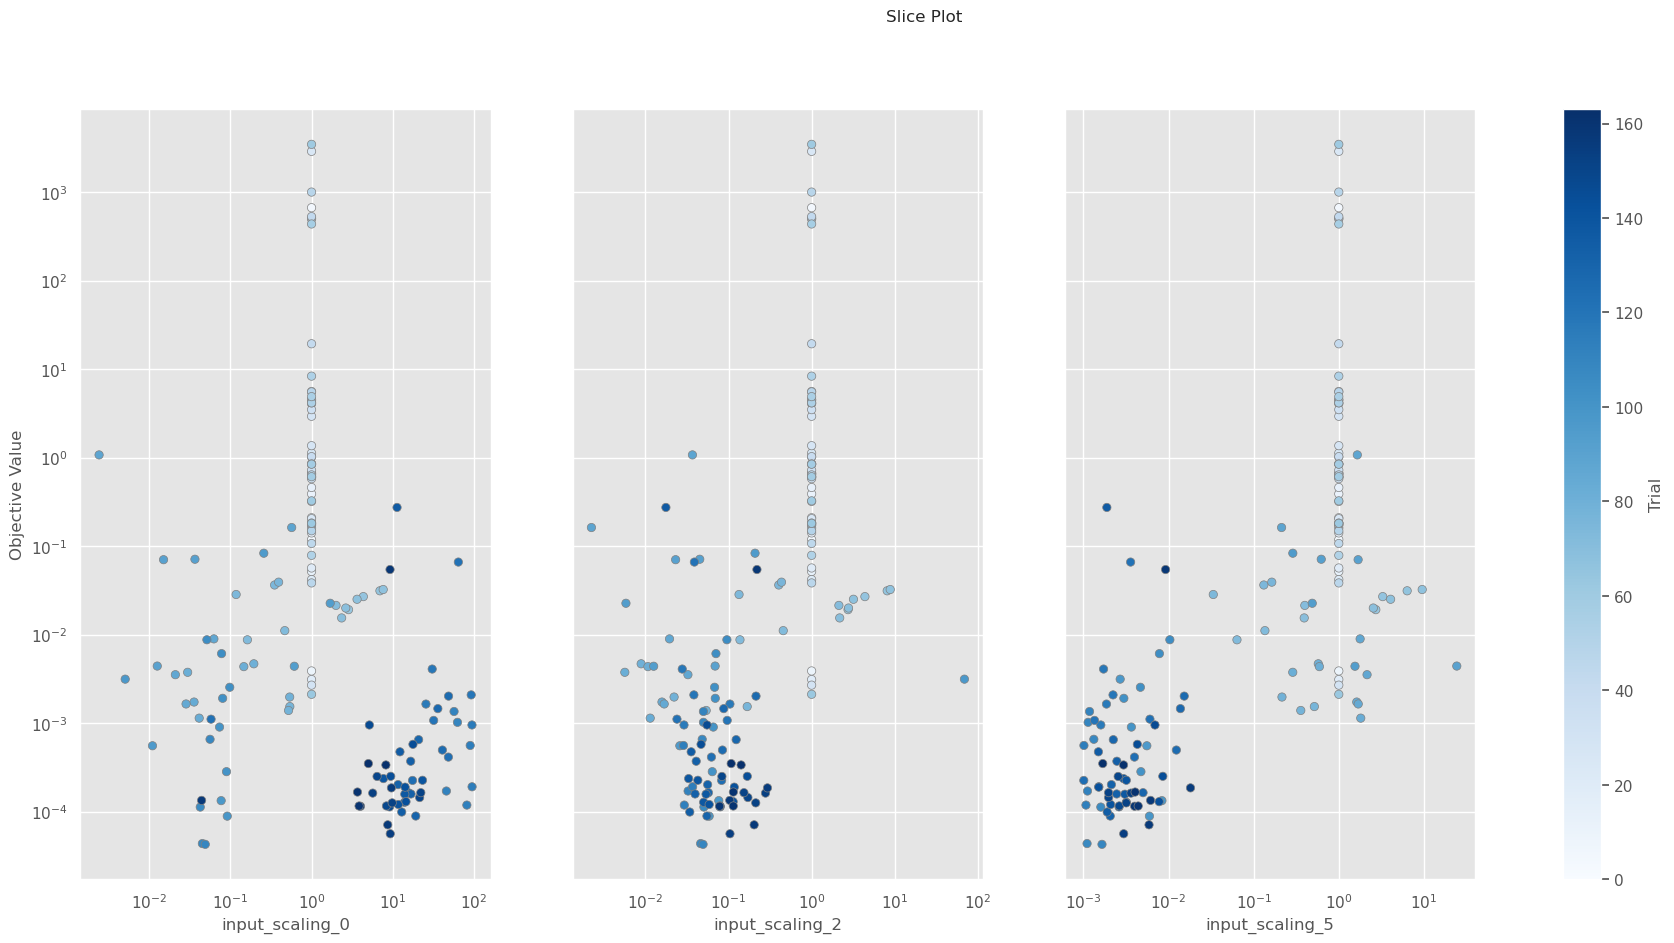

In [32]:
axes = plot_slice(
    study,
    params=[
        "input_scaling_0",  # x1
        # "input_scaling_1", # x2
        "input_scaling_2",  # x3
        # "input_scaling_3", # x4
        # "input_scaling_4", # x5
        "input_scaling_5",  # x6
        # "input_scaling_6", # x7
    ],
)
ax = axes[0]
ax.set_yscale("log")

Nnnnope! We will try with more random trials to reduce the risk of local minima.

# Summary

In [33]:
studies_titles = {
    "Baseline: Capacity": "Cheat-Capacity",
    "Baseline: Generalization": "Cheat-Generalization",
    "Baseline: Generalization with Noise": "Cheat-Noisy-Generalization",
}

/tmp/ipykernel_43296/703725100.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
/tmp/ipykernel_43296/703725100.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
/tmp/ipykernel_43296/703725100.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


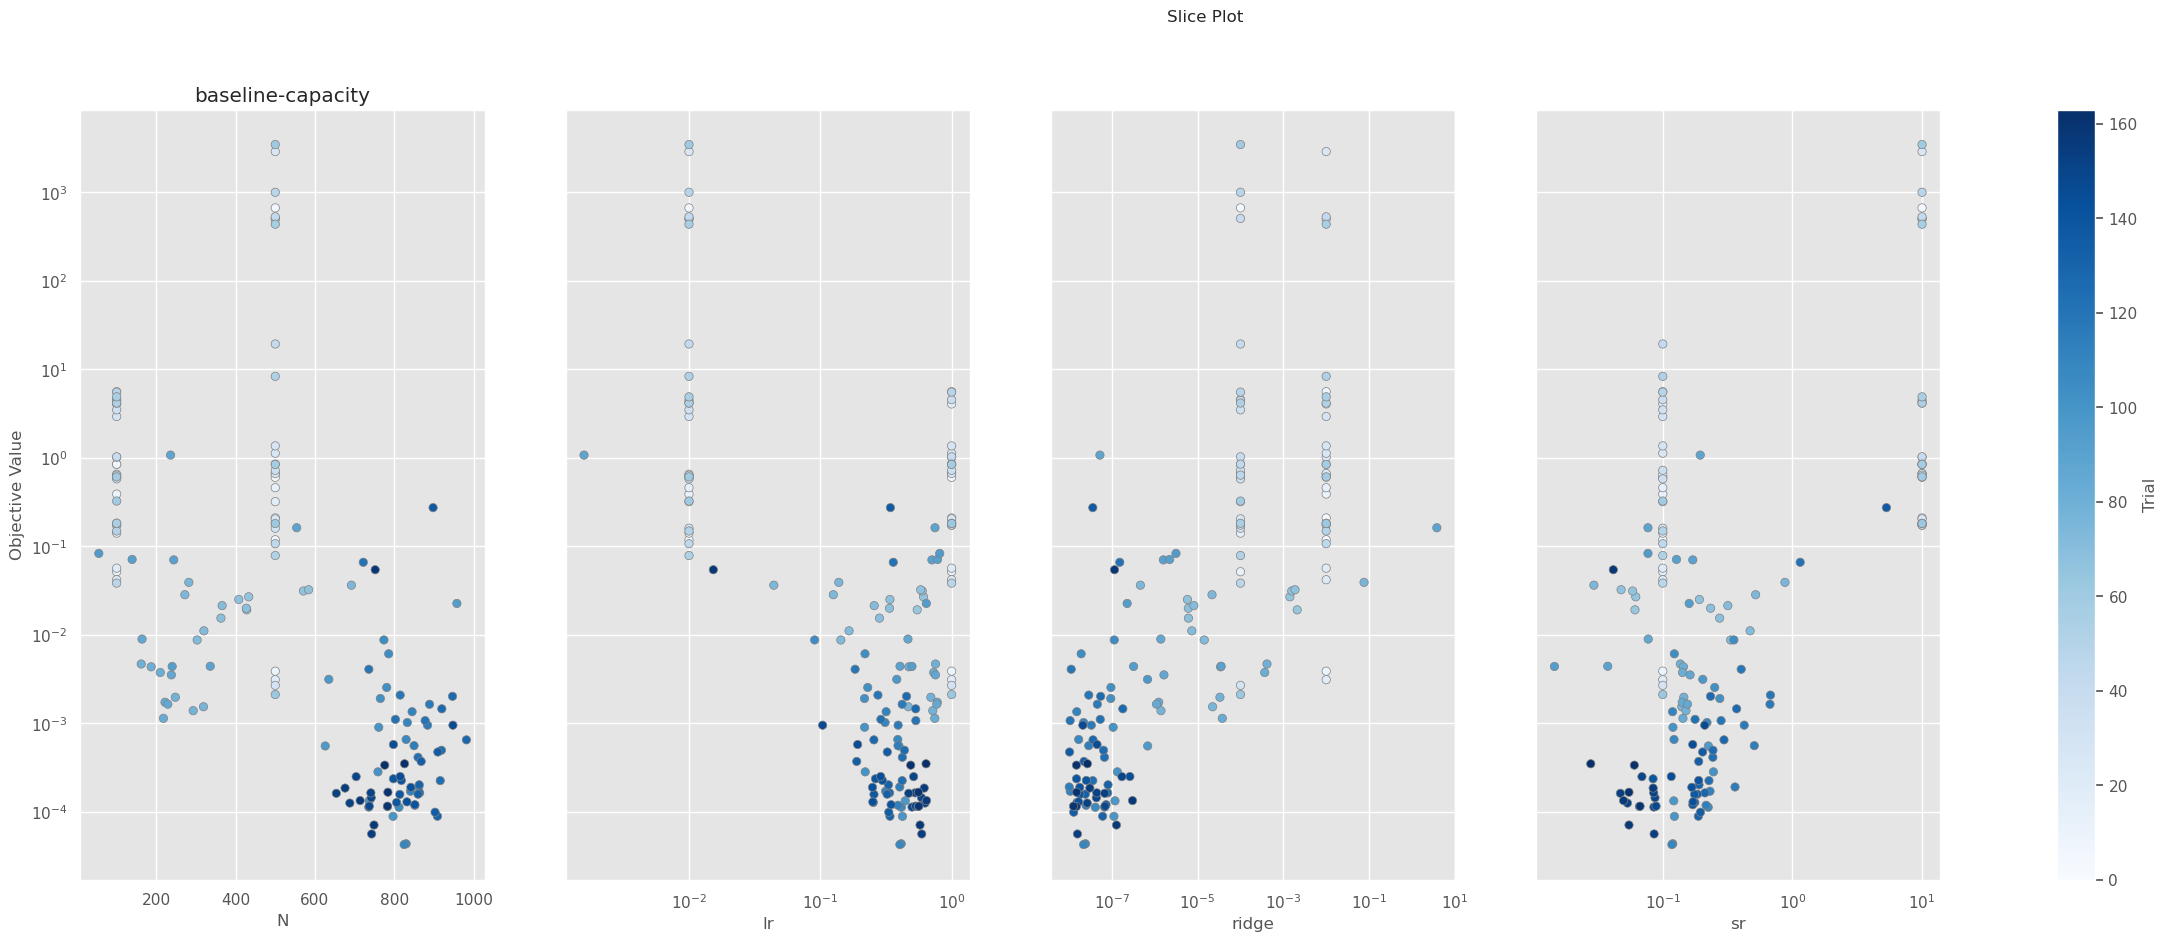

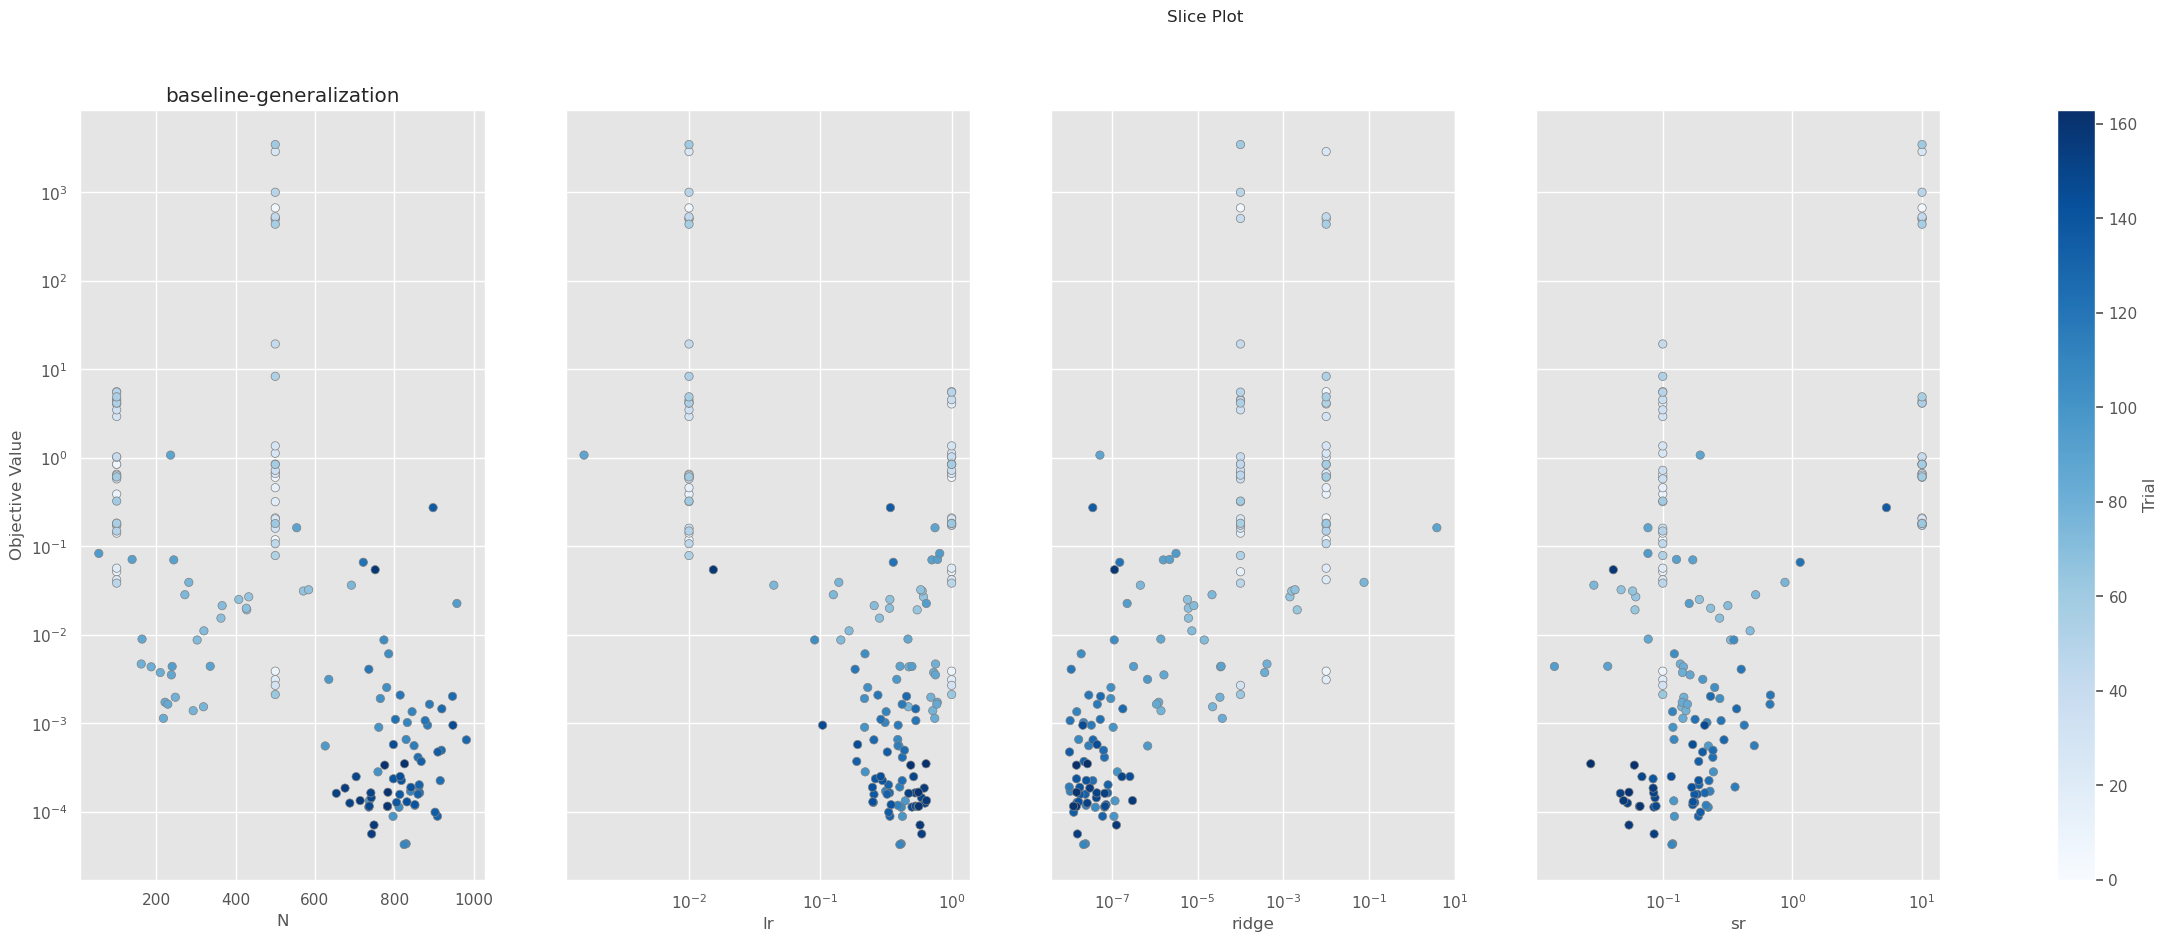

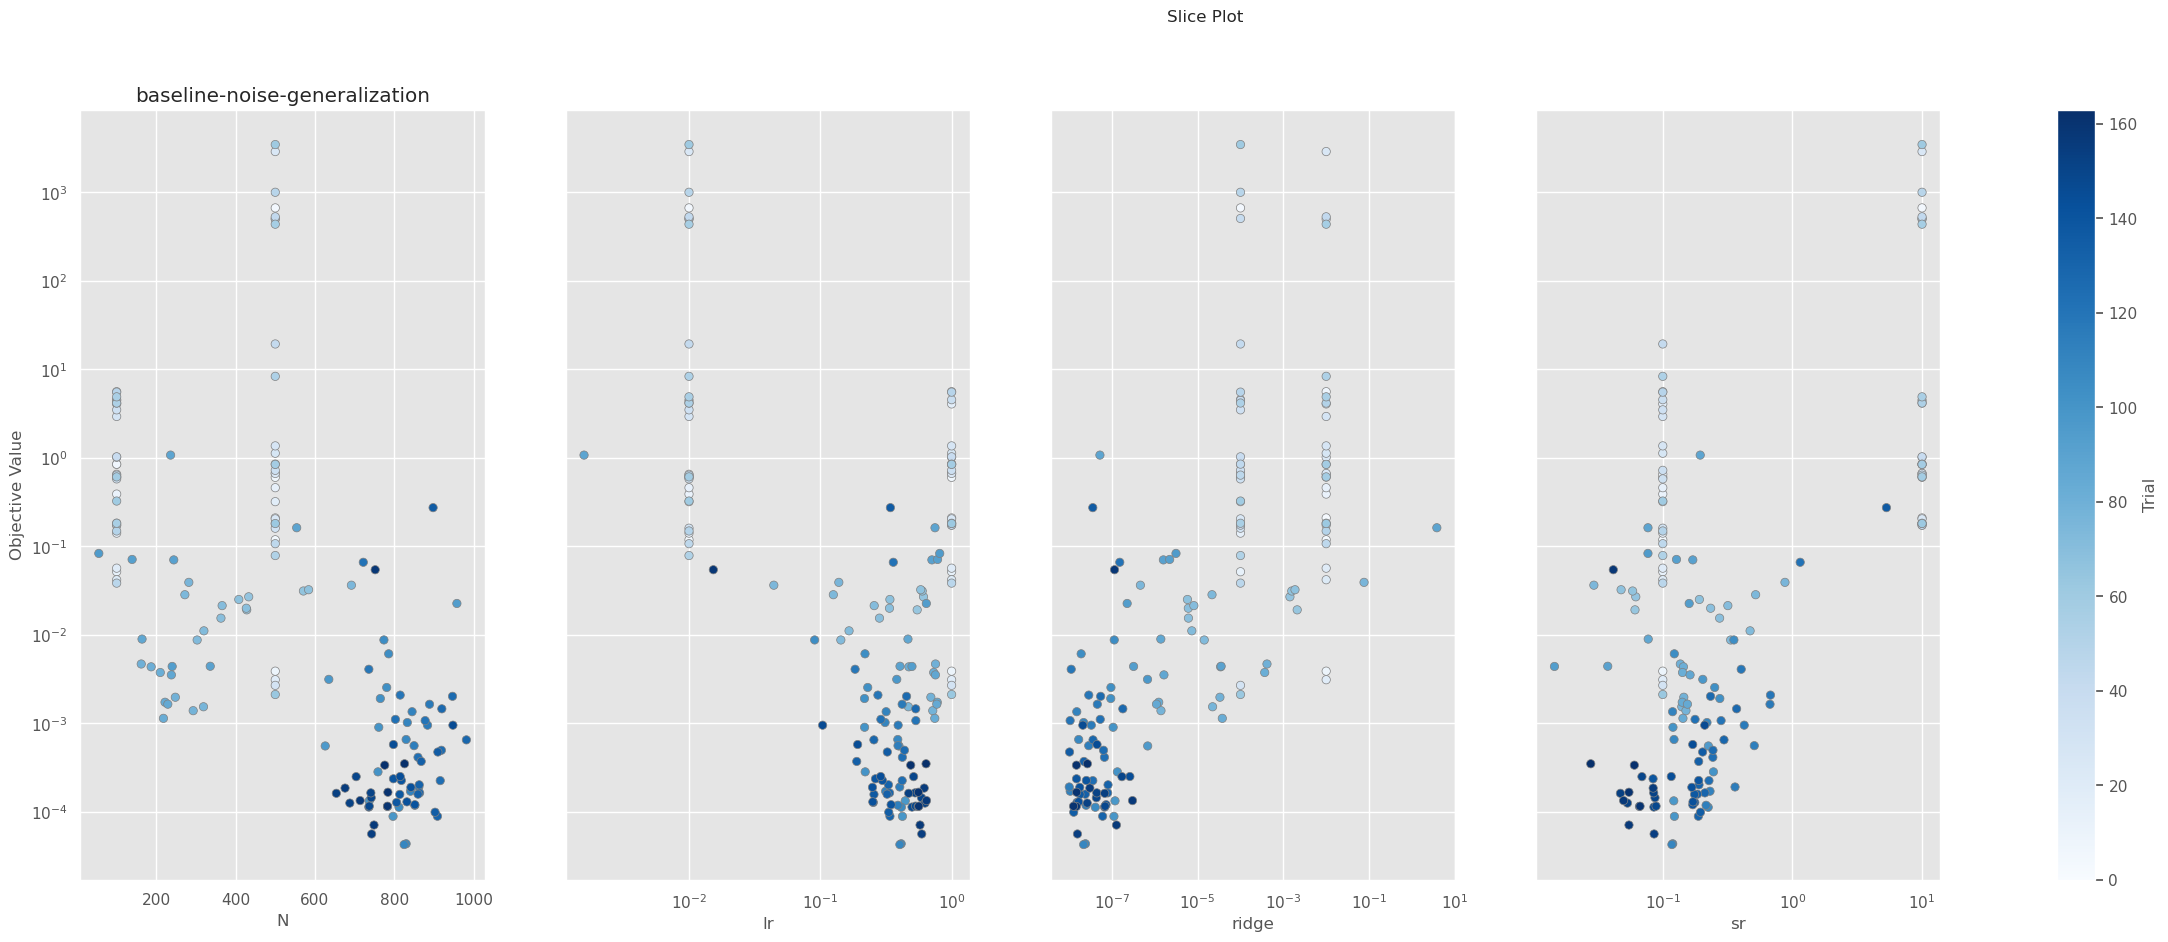

In [35]:
for title, study_name in studies.items():

    db_name = f"{STUDY_NAME}.db"
    df_name = f"{STUDY_NAME}.pkl"
    storage_name = f"sqlite:///{db_name}"

    study = optuna.load_study(
        study_name=STUDY_NAME,
        storage=storage_name,
    )

    axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
    ax = axes[0]
    ax.set_title(title)
    ax.set_yscale("log")